In [19]:
from datasets import load_dataset
from torch.utils.data import DataLoader
from fastprogress.fastprogress import master_bar, progress_bar
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from compressai.models import CompressionModel
from compressai.entropy_models import EntropyBottleneck
from compressai.layers import GDN1
import PIL
from torchvision.transforms import ToPILImage
from IPython.display import display
import zlib
from evaluate import evaluator
from transformers import AutoImageProcessor, AutoModelForImageClassification, pipeline
import torch.nn.functional as nnf

In [2]:
checkpoint = torch.load("checkpoint_dino_rdae_215.pth", map_location={'cuda:0': 'cpu'})
# checkpoint = torch.load("checkpoint_dino_rdae_215.pth")

In [3]:
imagenet_valid = load_dataset("danjacobellis/imagenet_dino",split='validation[0:100]').with_format("torch")

Resolving data files:   0%|          | 0/41 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/41 [00:00<?, ?it/s]

In [4]:
def conv(in_channels, out_channels, kernel_size=5, stride=2, groups=32):
    return nn.Conv2d(
        in_channels,
        out_channels,
        kernel_size=kernel_size,
        stride=stride,
        padding=kernel_size // 2,
        groups=groups
    )

In [5]:
def deconv(in_channels, out_channels, kernel_size=5, stride=2, groups=32):
    return nn.ConvTranspose2d(
        in_channels,
        out_channels,
        kernel_size=kernel_size,
        stride=stride,
        output_padding=stride - 1,
        padding=kernel_size // 2,
        groups=groups
    )

In [6]:
class RateDistortionAutoEncoder(CompressionModel):
    def __init__(self, N=4096):
        super().__init__()
        self.entropy_bottleneck = EntropyBottleneck(N)
        self.encode = nn.Sequential(
            conv(1536, N, kernel_size=1, stride=1),
            GDN1(N),
            conv(N, N, kernel_size=5, stride=2),
            # GDN1(N),
            # conv(N, N, kernel_size=5, stride=2),
        )

        self.decode = nn.Sequential(
            # deconv(N, N, kernel_size=5, stride=2),
            # GDN1(N, inverse=True),
            deconv(N, N, kernel_size=5, stride=2),
            GDN1(N, inverse=True),
            deconv(N, 1536, kernel_size=1, stride=1),
        )

    def forward(self, x):
        y = self.encode(x)
        y_hat, y_likelihoods = self.entropy_bottleneck(y)
        x_hat = self.decode(y_hat)
        return x_hat, y_likelihoods

In [7]:
net = RateDistortionAutoEncoder()
net.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [8]:
def lossy_compress_patch_tokens(sample):
    with torch.no_grad():
        x = sample['patch_tokens']
        xr = x.reshape((1,16,16,1536)).permute((0,3,1,2))
        z = net.encode(xr)
        z = z.round()
        z = z.clamp(-128,127)
        z = z.to(torch.int8)
        z = z.numpy()
        original_shape = z.shape
        compressed = zlib.compress(z.tobytes(), level=9)
        decompressed = zlib.decompress(compressed)
        ẑ = np.frombuffer(decompressed, dtype=np.int8)
        ẑ = ẑ.reshape(original_shape)
        ẑ = torch.tensor(ẑ)
        ẑ = ẑ.to(torch.float)
        x̂ = net.decode(ẑ)
        x̂ = x̂.permute((0, 2, 3, 1)).reshape((1, 256, 1536))
        sample['patch_tokens'] = x̂
        sample['bps'] = 8*len(compressed)/(1536*16*16)
        return sample

In [9]:
imagenet_valid = imagenet_valid.map(lossy_compress_patch_tokens)

In [10]:
model = AutoModelForImageClassification.from_pretrained('facebook/dinov2-giant-imagenet1k-1-layer').to("cuda") 

In [11]:
resnet = AutoModelForImageClassification.from_pretrained("microsoft/resnet-50")
label2id = resnet.config.label2id
del resnet

In [12]:
%%time
n_correct = 0
for sample in imagenet_valid:
    label = sample['label']
    cls_token = sample['cls_token']
    patch_tokens = sample['patch_tokens']
    linear_input = torch.cat([cls_token, patch_tokens.mean(dim=1)], dim=1).to("cuda")
    y = model.classifier(linear_input)[0].argmax().cpu()
    if (label == y):
        n_correct+=1;
acc = n_correct/imagenet_valid.num_rows

CPU times: user 3.97 s, sys: 0 ns, total: 3.97 s
Wall time: 175 ms


In [13]:
acc

0.86

In [14]:
x = imagenet_valid[10]['patch_tokens'].reshape((1,16,16,1536)).permute((0,3,1,2))

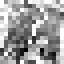

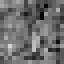

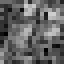

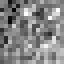

In [15]:
for c in range(4):
    z = x[0,c,:,:]
    z = z.clamp(-3,3)
    z = z/6 + 0.5
    z = (255*z).round().to(torch.uint8)
    display(ToPILImage()(z).resize((64,64),PIL.Image.NEAREST))

In [16]:
class LinearSegmentationHead(nn.Module):
    def __init__(self, in_channels=1536, num_classes=150):
        super(LinearSegmentationHead, self).__init__()
        self.conv_seg = nn.Conv2d(in_channels, num_classes, kernel_size=1)
        self.bn = nn.BatchNorm2d(in_channels)

    def forward(self, x):
        x = self.bn(x)
        x = self.conv_seg(x)
        return x

In [17]:
seg_checkpoint = torch.load("dinov2_vitg14_ade20k_linear_head.pth")
new_state_dict = {key.replace("decode_head.", ""): value for key, value in seg_checkpoint['state_dict'].items()}
seg_model = LinearSegmentationHead()
seg_model.load_state_dict(new_state_dict)

<All keys matched successfully>

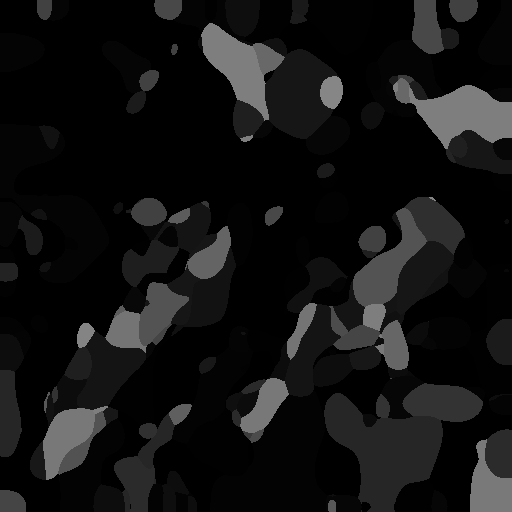

In [23]:
y = nnf.interpolate(x, size=(512, 512), mode='bicubic', align_corners=False)
z = seg_model(y).argmax(dim=1)
ToPILImage()(z[0].to(torch.uint8))